In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('/kaggle/input/u-novus/data/all.csv')

df['Период'] = pd.to_datetime(df['Период'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df = df.dropna(subset=['Период'])
df = df.sort_values(by='Период', ascending=True)


label_encoder = LabelEncoder()
df['Пост мониторинга'] = label_encoder.fit_transform(df['Пост мониторинга'])


df = df.dropna()
columns_to_drop = ['NO2', 'O3', 'H2S', 'CO', 'SO2']
df = df.drop(columns=columns_to_drop)

df.head()

,Пост мониторинга,Период,"Температура, °С","Давление, мм рт. ст.","Влажность, %","Скорость ветра, м/с","Направление ветра, °"
1,0,2025-02-19 11:00:00,-6.690,761.567629,74.570,0.150,143.00
2,0,2025-02-19 11:20:00,-6.575,761.612633,72.430,0.150,146.65
3,0,2025-02-19 11:40:00,-6.680,761.612633,72.275,0.153,154.75
4,0,2025-02-19 12:00:00,-7.215,761.680138,73.530,0.150,143.85
5,0,2025-02-19 12:20:00,-7.060,761.687639,75.530,0.150,126.70


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

df_test = pd.read_csv('/kaggle/input/u-novus/data/test.csv')

df_test['Период'] = pd.to_datetime(df_test['Период'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_test = df_test.dropna(subset=['Период'])
df_test = df_test.sort_values(by='Период', ascending=True)


label_encoder = LabelEncoder()
df_test['Пост мониторинга'] = label_encoder.fit_transform(df_test['Пост мониторинга'])


df_test = df_test.dropna()
columns_to_drop = ['NO2', 'O3', 'H2S', 'CO', 'SO2']
df_test = df_test.drop(columns=columns_to_drop)

TEST_X = df_test[['Пост мониторинга', 'Период']]
TEST_Y = df_test[['Температура, °С', 'Давление, мм рт. ст.', 'Влажность, %', 'Скорость ветра, м/с', 'Направление ветра, °']]

print("X_test:")
print(TEST_X.head())
print("\ny_test:")
print(TEST_Y.head())

X_test:
   Пост мониторинга              Период
0                 0 2025-05-20 00:00:00
1                 0 2025-05-20 00:20:00
2                 0 2025-05-20 00:40:00
3                 0 2025-05-20 01:00:00
4                 0 2025-05-20 01:20:00

y_test:
   Температура, °С  Давление, мм рт. ст.  Влажность, %  Скорость ветра, м/с  \
0           13.460            742.336048        93.130                 0.15   
1           13.535            742.156033        93.315                 0.15   
2           13.555            741.916013        93.440                 0.15   
3           13.575            741.675993        93.550                 0.15   
4           13.500            741.518480        93.670                 0.15   

   Направление ветра, °  
0                115.30  
1                149.75  
2                226.35  
3                269.00  
4                282.50  


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

input_steps = 144  
output_steps = 72  
feature_cols = ['Температура, °С', 'Давление, мм рт. ст.', 'Влажность, %', 'Скорость ветра, м/с', 'Направление ветра, °']

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[feature_cols])

X, Y = [], []
max_index = len(data_scaled) - input_steps - output_steps

for i in range(max_index - output_steps):
    x_i = data_scaled[i:i + input_steps]
    y_i = data_scaled[i + input_steps:i + input_steps + output_steps]
    X.append(x_i)
    Y.append(y_i)

X = np.array(X)  
Y = np.array(Y)  

print("X shape:", X.shape)
print("Y shape:", Y.shape)

2025-05-21 18:27:14.058363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747852034.278368      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747852034.343628      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


X shape: (6097, 144, 5)
Y shape: (6097, 72, 5)


In [5]:
total_samples = len(X)

train_end = int(total_samples * 0.8)
val_start = train_end + output_steps 

val_end = int(total_samples * 0.9)

X_train = X[:train_end]
Y_train = Y[:train_end]

X_val = X[val_start:val_end]
Y_val = Y[val_start:val_end]

X_finetune = X[val_end:]
Y_finetune = Y[val_end:]

print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(4877, 144, 5)
(4877, 72, 5)
(538, 144, 5)
(538, 72, 5)


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense


from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import Callback

class R2Callback(Callback):
    def __init__(self, X_val, Y_val, feature_names):
        super().__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.feature_names = feature_names
        self.output_steps = Y_val.shape[1]
        self.n_features = Y_val.shape[2]

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred = y_pred.reshape((-1, self.output_steps, self.n_features))
        y_true = self.Y_val

        r2s = []
        for i, name in enumerate(self.feature_names):
            r2 = r2_score(
                y_true[:, :, i].flatten(),
                y_pred[:, :, i].flatten()
            )
            r2s.append(f"{name}: {r2:.4f}")
        
        print(f"Epoch {epoch+1} R2 Scores → {' | '.join(r2s)}")



model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(input_steps, len(feature_cols))),
    Dropout(0.3),
    LSTM(192, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dense(output_steps * len(feature_cols))  
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

r2_callback = R2Callback(X_val, Y_val, feature_cols)

history = model.fit(
    X_train,
    Y_train.reshape((Y_train.shape[0], -1)),
    validation_data=(X_val, Y_val.reshape((Y_val.shape[0], -1))),
    epochs=50,
    batch_size=16,
    callbacks=[r2_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1830Epoch 1 R2 Scores → Температура, °С: -2.1758 | Давление, мм рт. ст.: -3.6626 | Влажность, %: -0.0442 | Скорость ветра, м/с: -0.0141 | Направление ветра, °: -0.1474
305/305 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - loss: 0.1828 - val_loss: 0.0423
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0458Epoch 2 R2 Scores → Температура, °С: -1.8277 | Давление, мм рт. ст.: -3.9794 | Влажность, %: -0.0019 | Скорость ветра, м/с: -0.0081 | Направление ветра, °: -0.0153
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0458 - val_loss: 0.0402
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0451Epoch 3 R2 Scores → Температура, °С: -1.8129 | Давление, мм рт. ст.: -3.5165 | Влажность, %: -0.0006 | Скорость ветра, м/с: -0.0160 | Направление ветра, °: -0.0135
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0451 - val_loss: 0.0394
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0447Epoch 4 R

In [17]:
history2 = model.fit(
    X_finetune,
    Y_finetune.reshape((Y_finetune.shape[0], -1)),
    epochs=30,  
    batch_size=32,
    verbose=1
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0257
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0128
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0103
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0091
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0085
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0082
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0076
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0076
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0075
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0073
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0073
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0072
Epoch 13/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0072
Epoch 14/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0069
Epoch 15/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0070
Epoc

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


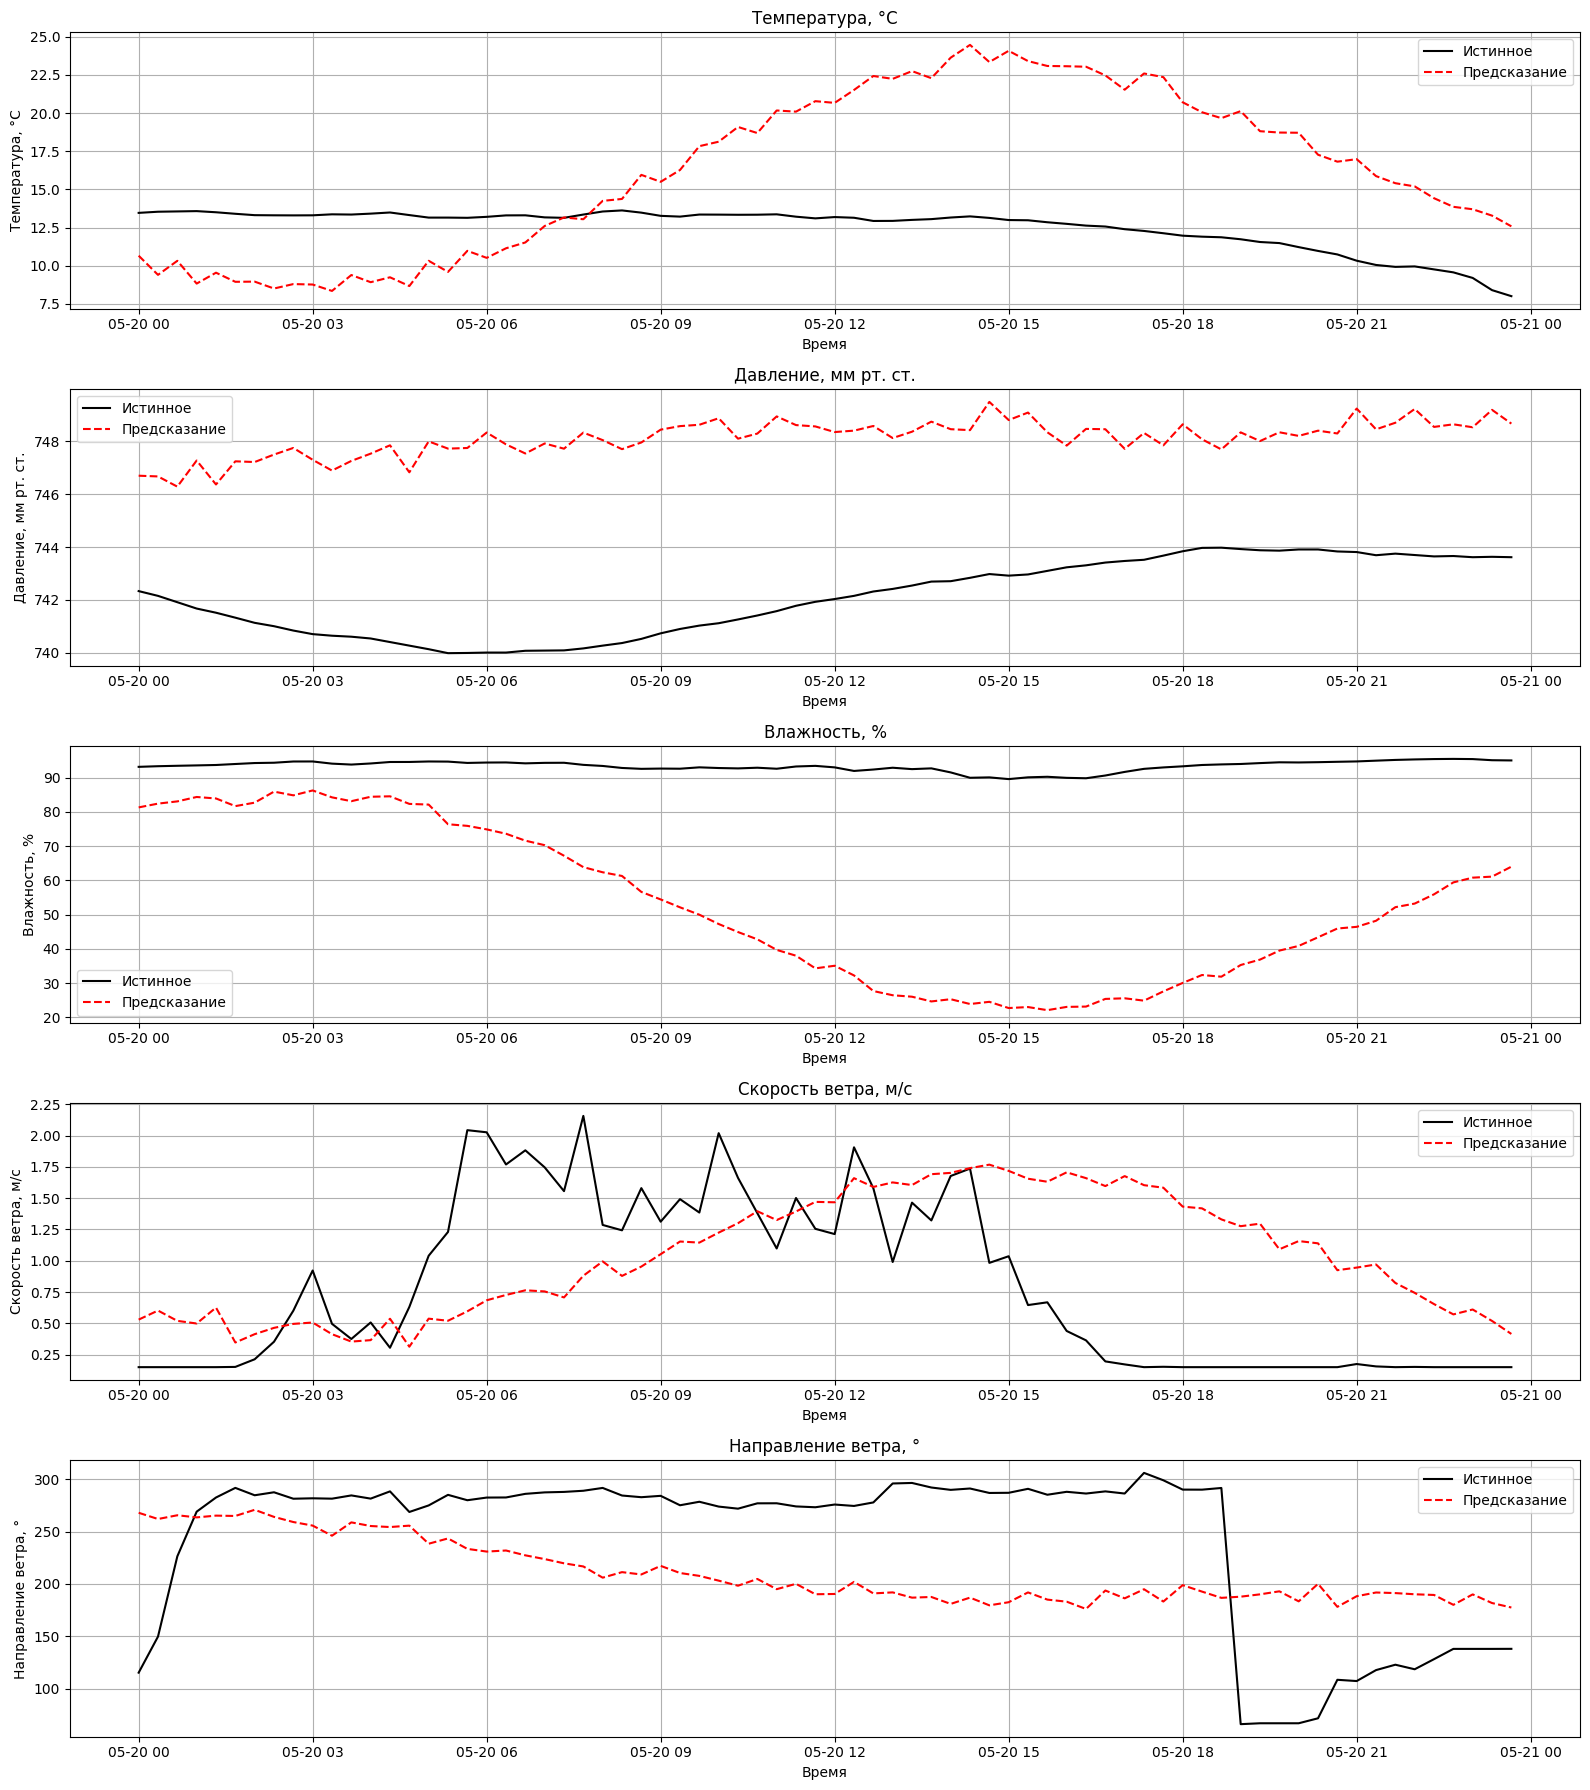

In [ ]:
import matplotlib.pyplot as plt

last_144 = df[feature_cols].tail(144).values 

# 2. Применить тот же scaler
last_144_scaled = scaler.transform(last_144)

X_test_input = np.expand_dims(last_144_scaled, axis=0) 

y_pred_scaled = model.predict(X_test_input, verbose=0)  # shape: (1, 72*5)
y_pred_scaled = y_pred_scaled.reshape((72, len(feature_cols)))


y_pred = scaler.inverse_transform(y_pred_scaled)


y_true = TEST_Y[feature_cols].values 

plt.figure(figsize=(16, 18))
time_range = TEST_X['Период'].values

for i, name in enumerate(feature_cols):
    plt.subplot(len(feature_cols), 1, i + 1)
    plt.plot(time_range, y_true[:, i], label='Истинное', color='black')
    plt.plot(time_range, y_pred[:, i], label='Предсказание', color='red', linestyle='--')
    plt.title(name)
    plt.xlabel('Время')
    plt.ylabel(name)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()